In [276]:
# basic data analytics
import pandas as pd
import numpy as np
import sklearn
import pickle
import time

# nlp modules
import nltk
import spacy
import re
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from collections import defaultdict

import multiprocessing
import string

import ktrain
from ktrain import text

from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfTransformer, TfidfVectorizer


import gensim
from gensim import corpora, models
from gensim.models.ldamulticore import LdaMulticore
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
import warnings

# warnings.simplefilter('once')
warnings.simplefilter('ignore')

num_processors = multiprocessing.cpu_count()
num_processors

workers = num_processors-1

print(f'Using {workers} workers')

Using 15 workers


In [332]:
df = pd.read_csv('/home/jupyter/df_news.csv', lineterminator='\n')

df = df.drop('Unnamed: 0', axis = 1)
df = df.drop(['text_notitle', 'split', 'split_len'], axis=1)
df = df.dropna(subset=['text_clean'])
df = df[df['text_clean'].str.contains('artificial intelligence|data science')]

import re

def remove_non_english_chars(text):
    # Pattern to match non-English characters
    pattern = r'[^a-zA-Z0-9\s]'
    
    # Replace non-English characters with an empty string
    cleaned_text = re.sub(pattern, '', text)
    
    return cleaned_text

# Apply the function to the 'text_clean' column of your DataFrame
df['text_clean'] = df['text_clean'].apply(remove_non_english_chars)

df['text_clean'] = df['text_clean'].astype(str)

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [ ]:
df.shape

In [ ]:
df.head(3)

## Creating Corpus

In [255]:

def clean(doc):
    stop = set(stopwords.words('english'))
    exclude = set(string.punctuation)
    lemma = WordNetLemmatizer()
    if type(doc) != str:
        return ''
    doc = ' '.join([i for i in doc.split() if len(i) < 20])
    doc = ' '.join([i for i in doc.split() if len(i) > 1])
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in word_tokenize(punc_free))
    normalized = normalized.replace('’', '')
    normalized = normalized.replace('“', '')
    normalized = normalized.replace('”', '')
    return normalized

def clean_process(doc_complete):
    
    stop = set(stopwords.words('english'))
    exclude = set(string.punctuation)
    lemma = WordNetLemmatizer()


    # Preprocess your documents
    start_time = time.time()
    cleaned_documents = [clean(doc) for doc in doc_complete]
    clean_time = time.time() - start_time
    print("Cleaning done in", clean_time, "seconds")

    # Split the cleaned documents into tokens
    start_time = time.time()
    tokenized_documents = [doc.split() for doc in cleaned_documents]
    tok_time = time.time() - start_time
    print("Tokenization done in", tok_time, "seconds")

    # Calculate word frequencies
    start_time = time.time()
    word_freq = defaultdict(int)
    for document in tokenized_documents:
        for word in document:
            word_freq[word] += 1
    freq_time = time.time() - start_time
    print("Frequency Calculation Time:", freq_time, "seconds")

    # Set the threshold for popular words
    threshold = 0.5  # Adjust this value according to your needs

    # Create a list of stop words based on the threshold
    start_time = time.time()
    stop_words = [word for word, freq in word_freq.items() if freq / len(tokenized_documents) > threshold]
    stop_words_time = time.time() - start_time
    print("Stop Words Creation Time:", stop_words_time, "seconds")

    # Filter out stop words from the tokenized documents
    start_time = time.time()
    filtered_documents = [[word for word in document if word not in stop_words] for document in tokenized_documents]
    filtering_time = time.time() - start_time
    print("Stop Words Filtering Time:", filtering_time, "seconds")
    
    return filtered_documents

In [268]:
%%time



# Define the number of topics
num_topics = 8

# Preprocess your news articles and create a list of documents
# Each document should be a list of tokens (words) representing an article

doc_complete = df['text_clean'].sample(2000).values.tolist()

filtered_documents = clean_process(doc_complete)


Cleaning done in 7.638181447982788 seconds
Tokenization done in 0.07109260559082031 seconds
Frequency Calculation Time: 0.20705389976501465 seconds
Stop Words Creation Time: 0.012348651885986328 seconds
Stop Words Filtering Time: 0.6645989418029785 seconds
CPU times: user 9.15 s, sys: 19.3 ms, total: 9.17 s
Wall time: 9.16 s


## Topic Modeling

### LDA way

In [269]:
    # Create a dictionary from the preprocessed and filtered documents
    start_time = time.time()
    dictionary = corpora.Dictionary(filtered_documents)
    dictionary_creation_time = time.time() - start_time
    print("Dictionary Creation Time:", dictionary_creation_time, "seconds")

    # Convert the dictionary into a bag-of-words representation
    start_time = time.time()
    corpus = [dictionary.doc2bow(doc) for doc in filtered_documents]
    corpus_creation_time = time.time() - start_time
    print("Corpus Creation Time:", corpus_creation_time, "seconds")

Dictionary Creation Time: 0.8974840641021729 seconds
Corpus Creation Time: 0.5322198867797852 seconds


In [274]:
lda_model = LdaMulticore(corpus=corpus,
                       id2word=dictionary,
                       num_topics=13,
                       random_state=100,                  
                       passes=10,
                       # alpha=a,
                       # eta=b,
                       workers=workers)
print('finished lda model')

coherence_model_lda = CoherenceModel(model=lda_model, texts=filtered_documents, dictionary=dictionary, coherence='c_v')

finished lda model


In [275]:
%%time

lda_display = gensimvis.prepare(lda_model, corpus, dictionary, sort_topics=False, mds='mmds')
pyLDAvis.display(lda_display)

CPU times: user 16.5 s, sys: 20.5 s, total: 37 s
Wall time: 5.66 s


In [52]:
coherence_model_lda.get_coherence()

0.33817695807787007

In [53]:
# supporting function
def compute_coherence_values(corpus, dictionary, k, a, b, texts):
    
    lda_model = LdaMulticore(corpus=corpus,
                       id2word=dictionary,
                       num_topics=k,
                       random_state=100,                  
                       passes=10,
                       alpha=a,
                       eta=b,
                       workers=workers)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=filtered_documents, dictionary=dictionary, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [54]:
start_time = time.time()

def tic():
    global start_time 
    start_time = time.time()

def tac():
    t_sec = round(time.time() - start_time)
    (t_min, t_sec) = divmod(t_sec,60)
    (t_hour,t_min) = divmod(t_min,60) 
    print(f'Execution time to calculate for topic {k}: {t_hour}hour:{t_min}min:{t_sec}sec'.format(t_hour,t_min,t_sec))

In [59]:
%%time

grid = {}
grid['Validation_Set'] = {}
# Topics range
min_topics = 2
max_topics = 15
step_size = 1
topics_range = range(min_topics, max_topics+1, step_size)

# Alpha parameter
# alpha = list(np.arange(0.01, 1, 0.3))
# alpha.append('symmetric')
# alpha.append('asymmetric')
alpha = ['asymmetric'] # Run for number of topics only

# Beta parameter
# beta = list(np.arange(0.01, 1, 0.3))
# beta.append('symmetric')
beta = ['auto'] # Run for number of topics only


# Validation sets
num_of_docs = len(corpus)
corpus_sets = [# gensim.utils.ClippedCorpus(doc_term_matrix, num_of_docs*0.25), 
               # gensim.utils.ClippedCorpus(doc_term_matrix, num_of_docs*0.5), 
#                gensim.utils.ClippedCorpus(doc_term_matrix, num_of_docs*0.75), 
               corpus]
# corpus_title = ['75% Corpus', '100% Corpus']
corpus_title = ['100% Corpus']
model_results = {
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

itr = 0
itr_total = len(beta)*len(alpha)*len(topics_range)*len(corpus_title)
print(f'LDA will execute {itr_total} iterations')

    
# iterate through hyperparameters
for i in range(len(corpus_sets)):
    # iterate through number of topics
    for k in topics_range:
        # iterate through alpha values
        tic()
        for a in alpha:
            # iterare through beta values
            for b in beta:
                # get the coherence score for the given parameters
                itr += 1
                cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=dictionary, 
                                              k=k, a=a, b=b, texts=filtered_documents)
                # Save the model results
                model_results['Topics'].append(k)
                model_results['Alpha'].append(a)
                model_results['Beta'].append(b)
                model_results['Coherence'].append(cv)
                pct_completed = round((itr / itr_total * 100),1)
#                 print(f'Completed Percent: {pct_completed}%, Corpus: {corpus_title[i]}, Topics: {k}, Alpha: {a}, Beta: {b}, Coherence: {cv}')
        print(f'Completed model based on {k} LDA topics. Finished {pct_completed}% of LDA runs')
        tac()
                    
lda_tuning_news = pd.DataFrame(model_results)
# path_lda = 'lda/'
# lda_tuning.to_csv(os.path.join(path_lda, 'lda_tuning_results.csv'), index=False)

LDA will execute 14 iterations
Completed model based on 2 LDA topics. Finished 7.1% of LDA runs
Execution time to calculate for topic 2: 0hour:0min:28sec
Completed model based on 3 LDA topics. Finished 14.3% of LDA runs
Execution time to calculate for topic 3: 0hour:0min:28sec
Completed model based on 4 LDA topics. Finished 21.4% of LDA runs
Execution time to calculate for topic 4: 0hour:0min:28sec
Completed model based on 5 LDA topics. Finished 28.6% of LDA runs
Execution time to calculate for topic 5: 0hour:0min:29sec
Completed model based on 6 LDA topics. Finished 35.7% of LDA runs
Execution time to calculate for topic 6: 0hour:0min:30sec
Completed model based on 7 LDA topics. Finished 42.9% of LDA runs
Execution time to calculate for topic 7: 0hour:0min:29sec
Completed model based on 8 LDA topics. Finished 50.0% of LDA runs
Execution time to calculate for topic 8: 0hour:0min:31sec
Completed model based on 9 LDA topics. Finished 57.1% of LDA runs
Execution time to calculate for topi

In [60]:
lda_tuning_news.sort_values(by=['Coherence'], ascending=False).head(10)

,Topics,Alpha,Beta,Coherence
11,13,asymmetric,auto,0.384578
9,11,asymmetric,auto,0.374026
0,2,asymmetric,auto,0.373766
8,10,asymmetric,auto,0.364975
5,7,asymmetric,auto,0.358021
12,14,asymmetric,auto,0.356641
6,8,asymmetric,auto,0.355151
3,5,asymmetric,auto,0.353184
10,12,asymmetric,auto,0.352968
13,15,asymmetric,auto,0.349821


<AxesSubplot:xlabel='Topics'>

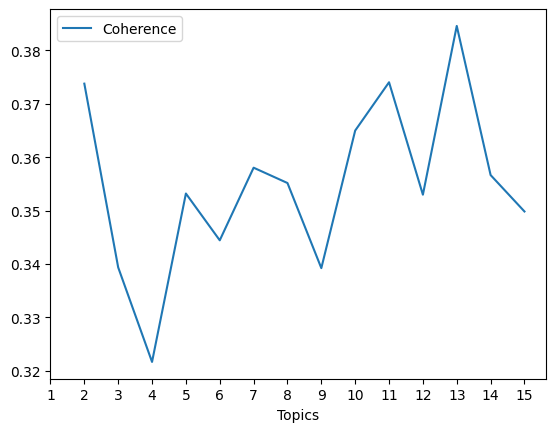

In [61]:
lda_tuning_news.plot(x ='Topics', y='Coherence', kind = 'line', xticks=range(1,16))

### Ktrain way

In [257]:
%%time
import ktrain
from ktrain import text

all_documents = [' '.join(item) for item in filtered_documents]

tm = ktrain.text.get_topic_model(
    texts=all_documents,
    n_topics=13, 
    n_features=10000,
    min_df=5,
    max_df=0.5,
    stop_words='english',
    model_type='lda',
    lda_max_iter=5,
    verbose=1)

lang: en
preprocessing texts...
fitting model...
iteration: 1 of max_iter: 5
iteration: 2 of max_iter: 5
iteration: 3 of max_iter: 5
iteration: 4 of max_iter: 5
iteration: 5 of max_iter: 5
done.
CPU times: user 17min 35s, sys: 13min 13s, total: 30min 48s
Wall time: 9min 30s


In [260]:
tm.print_topics()

topic 0 | stock fund investment investor distribution capital price return network trading
topic 1 | government state india security risk law right privacy policy china
topic 2 | drug day discovery covid19 researcher disease medicine scientist lab cell
topic 3 | student university education program school skill institute project course innovation
topic 4 | energy financial management risk process sector operation supply change increase
topic 5 | say image example thing think algorithm problem question different computer
topic 6 | medical clinical care healthcare cancer imaging hospital disease treatment image
topic 7 | cloud edge computing nvidia network device chip computer vision smart
topic 8 | forecast player trend region size opportunity provides segment factor revenue
topic 9 | enterprise organization partner insight capability analytics today leading process ceo
topic 10 | gray release press statement view http content reflect television original
topic 11 | google microsoft open

In [266]:
tm.build(df['text_clean'], threshold=0.25)


done.


In [267]:
tm.visualize_documents(doc_topics=tm.get_doctopics())

In [262]:
# Convert ktrain LDA model to gensim LDA model
gensim_lda_model = tm.model

# Convert the LDA model to pyLDAvis format
vis_data = pyLDAvis.gensim_models.prepare(gensim_lda_model, tm.tokenized_corpus, lda_model.tokenizer)

# Visualize the topics
pyLDAvis.display(vis_data)


AttributeError: 'TopicModel' object has no attribute 'tokenized_corpus'

## NER

In [8]:
# def extract_entities(indices):
#     entities = []
#     batch_size = len(indices)
#     texts = df.loc[indices, 'text_clean']
#     docs = nlp.pipe(texts, disable=["tok2vec", "tagger", "parser", "attribute_ruler", "lemmatizer"])

#     for i in range(0,batch_size):
#         index = indices[i]
#         doc = next(docs)
#         for ent in doc.ents:
#             if ent.label_ in ['PERSON', 'ORG', 'PRODUCT', 'EVENT']:
#                 entities.append((index, ent.text, ent.label_))

#     return entities

# %%time
# from pandarallel import pandarallel

# start_time = time.time()

# # Initialize Pandarallel
# pandarallel.initialize()

# # Load the spaCy NLP model
# nlp = spacy.load("en_core_web_md")

# # Function to extract entities using spaCy

# # divide index into batches

# index_batches = np.array_split(df.tail(91000).index.values, 100)

# # apply function to each batch

# ner_df = pd.Series(index_batches).parallel_apply(extract_entities)

# ner_time = time.time() - start_time


# print("NER Time:", ner_time, "seconds")

In [9]:
# ner_df = pd.DataFrame([item for sublist in ner_df for item in sublist], columns=['index', 'entity', 'label'])

In [10]:
# ner_df.to_csv('/home/jupyter/ner_tail91k.csv')

In [5]:
ner1 = pd.read_csv('/home/jupyter/ner_first99999.csv')
ner2 = pd.read_csv('/home/jupyter/ner_tail91k.csv')

In [6]:
ner_df = pd.concat([ner1, ner2], axis=0)

In [7]:
ner_df = ner_df.drop(['Unnamed: 0'], axis=1)

ner_df = ner_df.drop_duplicates()

ner_df = ner_df.merge(df['date'], left_on='index', right_index=True)

ner_df = ner_df[ner_df['entity'].str.len() <= 30]
ner_df = ner_df[ner_df['entity'].str.len() >= 2]
ner_df = ner_df[ner_df['entity'].str.contains('gray') == False]
ner_df = ner_df[ner_df['entity'].str.contains('https') == False]


In [8]:
ner_df.head(10)

,index,entity,label,date
1,0,miit,PERSON,2021-03-18
2,0,aipark,PERSON,2021-03-18
3,0,beijingchina ’ s,ORG,2021-03-18
4,0,technologycheetah,ORG,2021-03-18
5,0,livesmicrosoft,PERSON,2021-03-18
21,3,max,ORG,2021-03-10
22,3,samsung,ORG,2021-03-10
23,3,ken hyers,PERSON,2021-03-10
25,3,strategy analytics,ORG,2021-03-10
27,3,"strategy analytics , inc.",ORG,2021-03-10


In [146]:
ner_person = ner_df[ner_df['label'] == 'PERSON'].groupby('entity').count().sort_values(by='index', ascending=False).reset_index()

ner_person = ner_person[ner_person['entity'].str.split().apply(len) == 2]

In [401]:
ner_df.groupby('entity').count().sort_values(by='index', ascending=False).head(20)

,index,label,date
entity,,,
chatgpt,14708,14708,14708
microsoft,13413,13413,13413
covid-19,9530,9530,9530
google,7901,7901,7901
amazon,5682,5682,5682
ibm,5434,5434,5434
ml,4164,4164,4164
dr.,3364,3364,3364
fda,2903,2903,2903


In [12]:
def show_org_sentiment(org):
    org_indices = ner_df[ner_df['entity'] == org]['index'].drop_duplicates().values
    # print('sentiment for', org)
    return cat_df[cat_df['index_y'].apply(lambda x: x in org_indices)].value_counts('sentiment')



In [13]:
show_org_sentiment('chatgpt')

sentiment
NEUTRAL     672
POSITIVE    413
NEGATIVE    190
dtype: int64

In [49]:
ner_df.head(3)

,index,entity,label,date
1,0,miit,PERSON,2021-03-18
2,0,aipark,PERSON,2021-03-18
3,0,beijingchina ’ s,ORG,2021-03-18


In [134]:
technologies = [
    "tensorflow",
    "pytorch",
    "keras",
    "conversational ai",
    "generative ai",
    "llm",
    "opencv",
    "transformer",
    "nlp",
    "xgboost",
    "caffe",
    "theano",
    "mlops",
    "h2o",
    "spark",
    "gpt-3",
    "gpt-4",
    "midjourney",
    "stablediffusion",
    "dall-e",
    "chatgpt",
    "bert",
    "weka"
]

In [133]:
min(ner_df[ner_df['entity'].str.contains('nlp')]['date'])

'2020-01-22'

In [135]:
earliest_dates = []
num_articles = []
for tech in technologies:
    earliest_dates.append(min(ner_df[ner_df['entity'].str.contains(tech)]['date']))
    num_articles.append(len(ner_df[ner_df['entity'].str.contains(tech)]['date']))
    print('finished', tech)

finished tensorflow
finished pytorch
finished keras
finished conversational ai
finished generative ai
finished llm
finished opencv
finished transformer
finished nlp
finished xgboost
finished caffe
finished theano
finished mlops
finished h2o
finished spark
finished gpt-3
finished gpt-4
finished midjourney
finished stablediffusion
finished dall-e
finished chatgpt
finished bert
finished weka


In [136]:

zipped = list(zip(technologies, earliest_dates, num_articles))

tech_mentions = pd.DataFrame(zipped, columns=['tech', 'earliest_date', 'num_articles'])

In [137]:
bard = ner_df[((ner_df['entity'].str.contains(r'\bbard\b', regex=True)) & (ner_df['label'] != 'PERSON')) | ((ner_df['label'] == 'PERSON') & (ner_df['entity'].str.contains('google bard')))]

bard_date = min(bard['date'])  # Minimum date value from bard DataFrame
bard_count = len(bard['date'])  # Count of dates in bard DataFrame

bard_dataframe = pd.DataFrame([['bard', bard_date, bard_count]], columns=['tech', 'earliest_date', 'num_articles'])

tech_mentions = pd.concat([tech_mentions, bard_dataframe], axis=0)

In [139]:
gan = ner_df[ner_df['entity'].str.contains(r'\bgan\b', regex=True)]

gan_date = min(gan['date'])  # Minimum date value from bard DataFrame
gan_count = len(gan['date'])  # Count of dates in bard DataFrame

gan_dataframe = pd.DataFrame([['gan', gan_date, gan_count]], columns=['tech', 'earliest_date', 'num_articles'])

tech_mentions = pd.concat([tech_mentions, gan_dataframe], axis=0)

In [144]:
tech_mentions['earliest_date'] = pd.to_datetime(tech_mentions['earliest_date'])

tech_mentions = tech_mentions.sort_values('earliest_date', ascending=False)

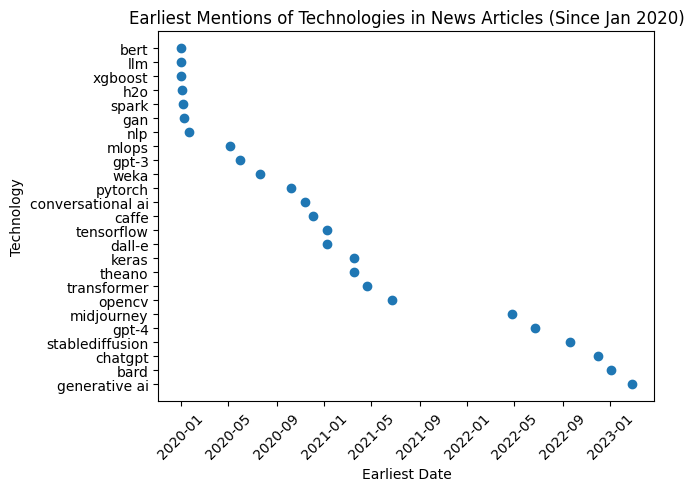

In [146]:
import matplotlib.pyplot as plt

# Create the plot
plt.scatter(tech_mentions['earliest_date'], tech_mentions['tech'])

# Set the plot labels and title
plt.xlabel('Earliest Date')
plt.ylabel('Technology')
plt.title('Earliest Mentions of Technologies in News Articles (Since Jan 2020)')

# Rotate the x-axis labels for better visibility
plt.xticks(rotation=45)

# Display the plot
plt.show()

In [245]:
top300_orgs = ner_df.groupby('entity').count().sort_values(by='index', ascending=False).reset_index().head(500)[['entity', 'label']]

In [249]:
companies = [
    'microsoft',
    'google',
    'amazon',
    'ibm',
    'apple',
    'netflix',
    'oracle',
    'samsung',
    'bloomberg',
    'baidu',
    'gartner',
    'deloitte',
    'sas',
    'siemens',
    'meta',
    'sony',
    'openai',
    'alphabet inc.',
    'ge healthcare',
    'darktrace',
    'cb insights',
    'boeing',
    'dell',
    'lg',
    'walmart',
    'roche',
    'vodafone',
    'infosys',
    'johnson & johnson',
    'apollo',
    'verizon',
    'yahoo',
    'bbc',
    'nvidia',
    'nvda',
    'spotify',
    'goldman sachs',
    'ford',
    'gm',
    'yahoo',
    'siemens',
    'medtronic',
    'airbus',
    'volvo',
    'bmw',
    'intel corporation',
    'sensetime',
    'hyundai',
    'redmond',
    'naver',
    'morgan stanley',
    'bank of america'
]

In [150]:
companies = ['sam altman',
 'satya nadella',
 'mark zuckerberg',
 'steve wozniak',
 'sundar pichai',
 'timnit gebru',
 'eric schmidt',
 'blake lemoine',
 'yoshua bengio',
 'robin li',
 'gary marcus',
 'james coomer',
 'margaret mitchell',
 'dan mcsweeney',
 'bill gates',
 'jensen huang',
 'alondra nelson',
 'james johnson']

In [250]:
companies_ner = top300_orgs[top300_orgs.entity.apply(lambda x: x in companies)]

In [398]:
# companies_ner

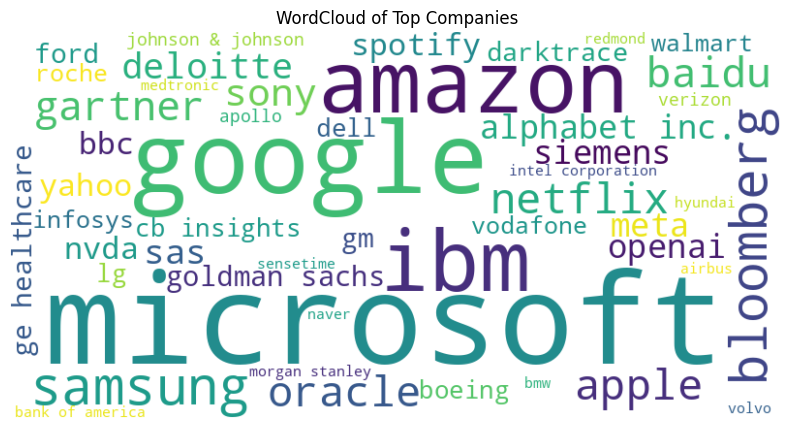

In [253]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Dictionary of entities and labels
entities_dict = dict(zip(companies_ner['entity'], companies_ner['label']))

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(entities_dict)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud of Top Companies')
plt.show()


In [128]:
# show_org_sentiment('nvidia')

sentiment
NEUTRAL     5
NEGATIVE    1
POSITIVE    1
dtype: int64

## Sentiment Analysis

In [11]:
# from ktrain.text.sentiment import SentimentAnalyzer
# from textblob import TextBlob
# classifier = SentimentAnalyzer()

# def detect_sentiment(indices):
#     sample = df.loc[indices, 'text_clean']
#     sentiments = []
#     batch_size = len(indices)
    
#     for i in range(0,batch_size):
#         # print('a')
#         index = list(indices)[i]
#         # print('b')
#         sents = TextBlob(df['text_clean'][index]).sentences
#         sents = [sentence.raw for sentence in sents]
#         # print('c')
#         item = ' '.join(sents[:2])
#         # print('d')
#         # take the bottom 500 characters
#         item = item[-500:]
#         # print(len(item))

#         sentiments.append((index, item, list(classifier.predict(item).keys())[0]))

        
    
#     return sentiments

In [12]:
# start_arr = np.arange(0, 29000, 1000)
# end_arr = np.arange(1000, 30000, 1000)

In [13]:
# start_arr = np.arange(29000, 30000, 50)
# end_arr = np.arange(29050, 30050, 50)

In [17]:
# all_sentiments = pd.DataFrame(columns=['index', 'excerpt', 'sentiment'])

In [18]:
# %%time
# from concurrent.futures import ThreadPoolExecutor
# from itertools import chain


# def parallel_detect_sentiment(indices):
#     with ThreadPoolExecutor() as executor:
#         results = executor.map(detect_sentiment, indices)
#     return list(results)

# for i in range(len(end_arr)):
#     start = start_arr[i]
#     end = end_arr[i]
#     indices = np.array_split(df.iloc[start:end].index.values, 20)
#     start_time = time.time()
#     sentiments = parallel_detect_sentiment(indices)
#     dur = time.time() - start_time
#     print(start, 'to', end, 'done in', dur, 'sec')
    
#     sentiments = list(chain.from_iterable(sentiments))
 
#     sent_df = pd.DataFrame(sentiments, columns=['index', 'excerpt', 'sentiment'])

#     all_sentiments = pd.concat([all_sentiments, sent_df], axis=0)



# all_sentiments.shape

0 to 1000 done in 78.12783980369568 sec
1000 to 2000 done in 79.53959035873413 sec
2000 to 3000 done in 77.80591058731079 sec
3000 to 4000 done in 78.13954544067383 sec
4000 to 5000 done in 77.72496938705444 sec
5000 to 6000 done in 78.33702993392944 sec
6000 to 7000 done in 77.6422028541565 sec
7000 to 8000 done in 77.57206845283508 sec
8000 to 9000 done in 77.65724611282349 sec
9000 to 10000 done in 77.16385293006897 sec
10000 to 11000 done in 77.13882756233215 sec
11000 to 12000 done in 77.70711278915405 sec
12000 to 13000 done in 77.34644293785095 sec
13000 to 14000 done in 76.92219471931458 sec
14000 to 15000 done in 77.08483147621155 sec
15000 to 16000 done in 77.68437099456787 sec
16000 to 17000 done in 77.63564658164978 sec
17000 to 18000 done in 77.48445224761963 sec
18000 to 19000 done in 77.00234770774841 sec
19000 to 20000 done in 77.12885427474976 sec
20000 to 21000 done in 78.0194022655487 sec
21000 to 22000 done in 77.70102834701538 sec
22000 to 23000 done in 77.64236211

(29000, 3)

In [19]:
# all_sentiments.merge(df, left_on='index', right_index=True).to_csv('/home/jupyter/sent_0_29.csv')

In [333]:
sent1 = pd.read_csv('/home/jupyter/sent_0_29.csv', lineterminator='\n')
sent2 = pd.read_csv('/home/jupyter/sent_29_75.csv', lineterminator='\n')
sent3 = pd.read_csv('/home/jupyter/sent_75_end.csv', lineterminator='\n')

sent_df = pd.concat([sent1, sent2, sent3], axis=0)
sent_df = sent_df.drop(['Unnamed: 0'], axis=1)

sent_df = sent_df.drop_duplicates()

In [334]:
sent_df.set_index('index', inplace=True)

In [335]:
sent_df['date'] = pd.to_datetime(sent_df['date'])
sent_df['month'] = sent_df['date'].apply(lambda x: x.strftime('%Y-%m'))

In [377]:
articles_bymonth = pd.DataFrame(sent_df.value_counts('month')).reset_index()

In [378]:
articles_bymonth = articles_bymonth.sort_values('month')

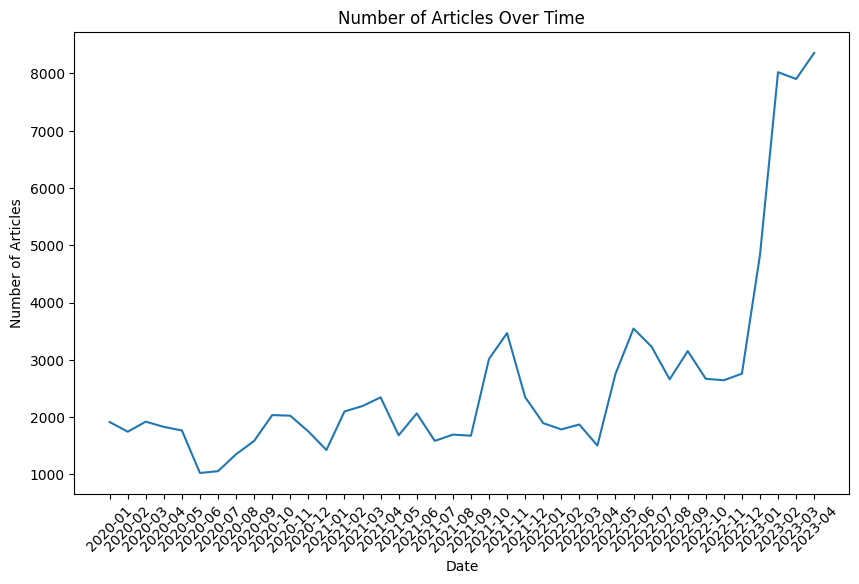

In [383]:
plt.figure(figsize=(10, 6))
plt.plot(articles_bymonth['month'], articles_bymonth[0])
plt.xlabel('Date')
plt.ylabel('Number of Articles')
plt.title('Number of Articles Over Time')
plt.xticks(rotation=45)
plt.show()

In [385]:
sent_df = sent_df.reset_index()
sent_bymonth = sent_df.groupby(['month', 'sentiment']).count().reset_index()[['month','sentiment','index']]

# Calculate the total count for each month
total_counts = sent_bymonth.groupby('month')['index'].sum()

# Calculate the percentage for each sentiment within each month
sent_bymonth['percentage'] = sent_bymonth.groupby('month')['index'].apply(lambda x: (x / x.sum()) * 100)

# Round the percentage to two decimal places
sent_bymonth['percentage'] = sent_bymonth['percentage'].round(2)

<Figure size 1000x600 with 0 Axes>

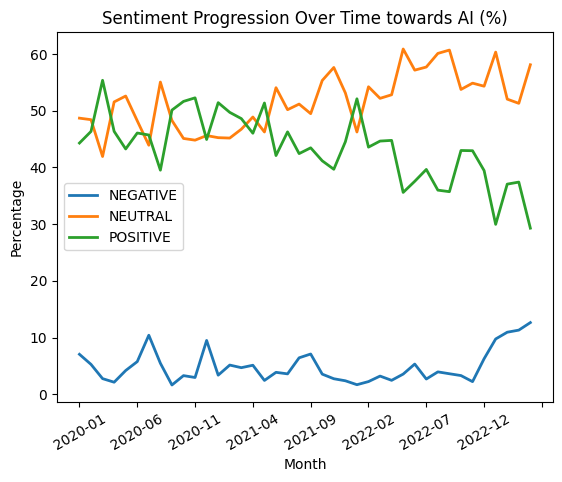

In [386]:
import matplotlib.pyplot as plt

# Group the data by sentiment and month
grouped_df = sent_bymonth.groupby(['sentiment', 'month']).sum().reset_index()

# Pivot the dataframe to have sentiments as columns
pivot_df = grouped_df.pivot(index='month', columns='sentiment', values='percentage')

# Set the figure background to transparent
plt.figure(figsize=(10, 6))
pivot_df.plot.line(marker='', linestyle='-', linewidth=2)

# Set plot title and labels
plt.title('Sentiment Progression Over Time towards AI (%)')
plt.xlabel('Month')
plt.ylabel('Percentage')

# Add a legend
plt.legend()
plt.xticks(rotation=30)

# Show the plot
plt.show()


In [74]:
# plt.savefig('/home/jupyter/sentiment_plot.png', transparent=True)

<Figure size 640x480 with 0 Axes>

In [67]:
# sent_df.sample(50)[['title', 'sentiment']].to_csv('/home/jupyter/sent_50_sample.csv')

In [43]:
negative_articles = sent_df[sent_df['sentiment'] == 'NEGATIVE']
neutral_articles = sent_df[sent_df['sentiment'] == 'NEUTRAL']
positive_articles = sent_df[sent_df['sentiment'] == 'POSITIVE']


In [165]:
positive_articles[positive_articles['title'].str.contains('The Retail')]

,index,excerpt,sentiment,url,date,language,title,text,text_clean,month
1286,2341,their complex solutions in a presentable way t...,POSITIVE,https://www.forbes.com/sites/forbestechcouncil...,2022-10-21,en,Simple Science: Why The Retail Industry Needs ...,Simple Science: Why The Retail Industry Needs ...,make everything as simple as possible but no...,2022-10
91967,166122,han ever ai can transform every aspect of ret...,POSITIVE,https://www.forbes.com/sites/forbestechcouncil...,2020-08-21,en,Council Post: Seven Ways Artificial Intelligen...,Council Post: Seven Ways Artificial Intelligen...,0700am edtseven ways artificial intelligence i...,2020-08


In [176]:
negative_articles['title'].sample(1).values

array(['     artificial intelligence: The 1997 chess game that thrust AI into the spotlight, CIO News, ET CIO'],
      dtype=object)

In [174]:
doc_complete = negative_articles['text_clean'].values.tolist()

filtered_documents = clean_process(doc_complete)

KeyboardInterrupt: 

In [80]:
all_documents = [' '.join(item) for item in filtered_documents]

tm = ktrain.text.get_topic_model(
    texts=all_documents,
    n_topics=5, 
    n_features=10000,
    min_df=5,
    max_df=0.5,
    stop_words='english',
    model_type='lda',
    lda_max_iter=5,
    verbose=1)

lang: en
preprocessing texts...
fitting model...
iteration: 1 of max_iter: 5
iteration: 2 of max_iter: 5
iteration: 3 of max_iter: 5
iteration: 4 of max_iter: 5
iteration: 5 of max_iter: 5
done.


In [400]:
tm.print_topics()

topic 0 | stock fund investment investor distribution capital price return network trading
topic 1 | government state india security risk law right privacy policy china
topic 2 | drug day discovery covid19 researcher disease medicine scientist lab cell
topic 3 | student university education program school skill institute project course innovation
topic 4 | energy financial management risk process sector operation supply change increase
topic 5 | say image example thing think algorithm problem question different computer
topic 6 | medical clinical care healthcare cancer imaging hospital disease treatment image
topic 7 | cloud edge computing nvidia network device chip computer vision smart
topic 8 | forecast player trend region size opportunity provides segment factor revenue
topic 9 | enterprise organization partner insight capability analytics today leading process ceo
topic 10 | gray release press statement view http content reflect television original
topic 11 | google microsoft open

## Targeted Sentiment

In [59]:
targeted_sent_df = pd.read_csv('/home/jupyter/df_news.csv', lineterminator='\n')

targeted_sent_df = targeted_sent_df.drop('Unnamed: 0', axis = 1)
targeted_sent_df = targeted_sent_df.drop(['text_notitle', 'split_len'], axis=1)
targeted_sent_df = targeted_sent_df.dropna(subset=['text_clean'])
targeted_sent_df = targeted_sent_df[targeted_sent_df['text_clean'].str.contains('artificial intelligence|data science')]

targeted_sent_df['text_clean'] = targeted_sent_df['text_clean'].apply(remove_non_english_chars)

targeted_sent_df['text_clean'] = targeted_sent_df['text_clean'].astype(str)

In [60]:
def get_org_df(org):
    org_indices = ner_df[ner_df['entity'] == org]['index'].drop_duplicates().values
    return targeted_sent_df[targeted_sent_df.index.isin(org_indices)]

In [61]:
def get_parags(org):
    ms = get_org_df(org)
    ms['split'] = ms['split'].apply(lambda x: eval(x))
    # ms['split'] = ms['split'].apply(lambda x: x.split('.'))
    return ms['split'].apply(lambda x: [p for p in x if org in str(p).lower()])

In [62]:
from ktrain.text.sentiment import SentimentAnalyzer
from textblob import TextBlob
classifier = SentimentAnalyzer()

In [189]:
%%time
# classifier.predict(ms.explode().iloc[1])

# list(classifier.predict(item).keys())[0]

CPU times: user 30.2 ms, sys: 4.79 ms, total: 34.9 ms
Wall time: 33.2 ms


In [63]:
def targeted_sentiment(indices):
    sample = selected_tgt_s.loc[indices]
    sentiments = []
    batch_size = len(indices)
    
    for i in range(0,batch_size):
        # print('a')
        index_for_texts = list(sample['index'])[i]
        index_for_sequence = list(indices)[i]
        # print('b')
        item = selected_tgt_s['split'].iloc[index_for_sequence]
        # print(len(item))

        sentiments.append((index_for_texts, item, list(classifier.predict(item).keys())[0]))

        
    
    return sentiments

In [ ]:
%%time
from concurrent.futures import ThreadPoolExecutor
from itertools import chain

def parallel_detect_t_sentiment(indices):
        with ThreadPoolExecutor() as executor:
            results = executor.map(targeted_sentiment, indices)
        return list(results)

# all_sentiments = pd.DataFrame(columns=['index','org', 'excerpt', 'sentiment'])

for org in companies:
    ms = get_parags(org)
    

    selected_tgt_s = ms.explode().apply(lambda x: x[0:499] if len(str(x)) > 500 else str(x))

    selected_tgt_s = pd.DataFrame(selected_tgt_s).reset_index()



    # start_arr = np.arange(0, 1600, 500)
    # end_arr = np.arange(500, 2100, 500)

        # start = start_arr[i]
        # end = end_arr[i]
        
    # print('a')
    indices = np.array_split(selected_tgt_s.sample(200).index.values, 20)
    # print('a')
    start_time = time.time()
    sentiments = parallel_detect_t_sentiment(indices)
    dur = time.time() - start_time
    print(0, 'to', 200, 'for', org, 'done in', dur, 'sec')

    sentiments = list(chain.from_iterable(sentiments))

    tsent_df = pd.DataFrame(sentiments, columns=['index', 'excerpt', 'sentiment'])
    
    tsent_df['org'] = org

    all_sentiments = pd.concat([all_sentiments, tsent_df], axis=0)
    





In [152]:
# all_sentiments.to_csv('/home/jupyter/top_people_sent.csv')

In [336]:
top_comp_ts_df = pd.read_csv('/home/jupyter/top_companies_sent.csv', lineterminator='\n')

top_comp_ts_df = top_comp_ts_df.drop(['Unnamed: 0'], axis=1)

top_comp_ts_df = top_comp_ts_df.drop_duplicates()

In [337]:
top_per_ts_df = pd.read_csv('/home/jupyter/top_people_sent.csv', lineterminator='\n')

top_per_ts_df = top_per_ts_df.drop(['Unnamed: 0'], axis=1)

top_per_ts_df = top_per_ts_df.drop_duplicates()

In [338]:
top_comp_ts_df.shape

(10182, 4)

In [339]:
top_per_ts_df.head(2)

,index,org,excerpt,sentiment
0,105141,sam altman,/PRNewswire/ -- Humane Inc. today announced i...,POSITIVE
1,53754,sam altman,", 10:58 AMROME -- Italy is temporarily blockin...",NEGATIVE


In [340]:
top_comp_ts_df.head(3)

,index,org,excerpt,sentiment
0,129509,microsoft,Key players in the global Embedded AI computin...,POSITIVE
1,165929,microsoft,"In April 2020, during the earliest days of the...",NEUTRAL
2,117121,microsoft,Microsoft has similarly said it will incorpora...,POSITIVE


In [341]:
target_sent_count = pd.DataFrame(top_comp_ts_df.value_counts(['org', 'sentiment'])).reset_index()
target_sent_count.columns = ['org', 'sentiment', 'count']

In [342]:
target_sent_p_count = pd.DataFrame(top_per_ts_df.value_counts(['org', 'sentiment'])).reset_index()
target_sent_p_count.columns = ['per', 'sentiment', 'count']

In [343]:
target_sent_count[target_sent_count['org'] == 'cb insights']

,org,sentiment,count
10,cb insights,POSITIVE,129
90,cb insights,NEUTRAL,69
138,cb insights,NEGATIVE,2


In [344]:
target_sent_p_count

,per,sentiment,count
0,james coomer,POSITIVE,199
1,steve wozniak,NEUTRAL,154
2,timnit gebru,NEUTRAL,152
3,jensen huang,POSITIVE,143
4,blake lemoine,NEUTRAL,139
5,yoshua bengio,NEUTRAL,135
6,satya nadella,POSITIVE,132
7,dan mcsweeney,POSITIVE,129
8,alondra nelson,NEUTRAL,127
9,eric schmidt,NEUTRAL,126


In [345]:
def get_pos_perc(org, sent):

    comp_sent_cnt = pd.DataFrame(top_comp_ts_df[top_comp_ts_df['org']==org][['excerpt', 'sentiment']].drop_duplicates().value_counts('sentiment')).reset_index()

    comp_sent_cnt.columns = ['sentiment', 'cnt']

    comp_sent_cnt = comp_sent_cnt.sort_values('cnt', ascending=False)

    # Calculate the percentage
    comp_sent_cnt['percentage'] = (comp_sent_cnt['cnt'] / comp_sent_cnt['cnt'].sum()) * 100
    
    if not comp_sent_cnt.loc[comp_sent_cnt['sentiment'] == sent, 'percentage'].empty:

        perc_for_pos = comp_sent_cnt.loc[comp_sent_cnt['sentiment'] == sent, 'percentage'].values[0]

        return perc_for_pos
    
    else:
        return None


def get_pos_perc_per(per, sent):

    comp_sent_cnt = pd.DataFrame(top_per_ts_df[top_per_ts_df['org']==per][['excerpt', 'sentiment']].drop_duplicates().value_counts('sentiment')).reset_index()

    comp_sent_cnt.columns = ['sentiment', 'cnt']

    comp_sent_cnt = comp_sent_cnt.sort_values('cnt', ascending=False)

    # Calculate the percentage
    comp_sent_cnt['percentage'] = (comp_sent_cnt['cnt'] / comp_sent_cnt['cnt'].sum()) * 100

    if not comp_sent_cnt.loc[comp_sent_cnt['sentiment'] == sent, 'percentage'].empty:
        perc_for_pos = comp_sent_cnt.loc[comp_sent_cnt['sentiment'] == sent, 'percentage'].values[0]

        return perc_for_pos
    else:
        return None
# comp_sent_cnt

In [346]:
orgs_distinct = target_sent_count['org'].drop_duplicates()


orgs_distinct = pd.concat([orgs_distinct, orgs_distinct.apply(lambda x: get_pos_perc(x, 'POSITIVE'))], axis=1)

orgs_distinct.columns = ['org', 'positive_perc']

orgs_distinct.sort_values('positive_perc', ascending=False)

,org,positive_perc
29,redmond,70.967742
23,nvda,65.806452
6,deloitte,64.331210
15,bank of america,62.264151
7,oracle,60.736196
10,cb insights,59.375000
19,apple,58.333333
35,sas,57.046980
32,naver,55.284553
34,morgan stanley,52.000000


In [354]:
top_comp_ts_df[top_comp_ts_df['org']=='deloitte'][['excerpt', 'sentiment']].drop_duplicates()

,excerpt,sentiment
2200,/PRNewswire/ -- Deloitte today unveiled Quart...,POSITIVE
2201,An award-winning solution already in market an...,POSITIVE
2202,/PRNewswire/ -- Deloitte today announced the ...,POSITIVE
2203,CampusLogic delivers SaaS technology that help...,POSITIVE
2204,Even though artificial intelligence was invent...,POSITIVE
...,...,...
2395,/PRNewswire/ -- Deloitte today introduced Rea...,POSITIVE
2396,"Financial services firms, in particular, are o...",POSITIVE
2397,The Deloitte AI Institute for Government serve...,POSITIVE
2398,"ChatGPT, other AI models to disrupt Indian IT ...",NEUTRAL


In [357]:
orgs_distinct = target_sent_count['org'].drop_duplicates()


orgs_distinct = pd.concat([orgs_distinct, orgs_distinct.apply(lambda x: get_pos_perc(x, 'NEGATIVE'))], axis=1)

orgs_distinct.columns = ['org', 'negative_perc']

orgs_distinct.sort_values('negative_perc', ascending=False)

,org,negative_perc
5,bbc,15.822785
57,netflix,12.426036
52,google,12.299465
2,yahoo,11.627907
61,spotify,10.909091
27,meta,10.555556
14,baidu,10.000000
39,openai,9.677419
36,goldman sachs,9.333333
20,nvidia,9.139785


In [349]:
per_distinct = target_sent_p_count['per'].drop_duplicates()


per_distinct = pd.concat([per_distinct, per_distinct.apply(lambda x: get_pos_perc_per(x, 'POSITIVE'))], axis=1)

per_distinct.columns = ['per', 'positive_perc']

per_distinct.sort_values('positive_perc', ascending=False)

,per,positive_perc
0,james coomer,96.774194
7,dan mcsweeney,70.000000
3,jensen huang,65.662651
6,satya nadella,63.157895
16,bill gates,46.842105
14,mark zuckerberg,39.548023
10,sundar pichai,39.130435
11,sam altman,32.934132
5,yoshua bengio,32.786885
13,robin li,26.865672


In [350]:
per_distinct = target_sent_p_count['per'].drop_duplicates()


per_distinct = pd.concat([per_distinct, per_distinct.apply(lambda x: get_pos_perc_per(x, 'NEGATIVE'))], axis=1)

per_distinct.columns = ['per', 'neg_perc']

per_distinct.sort_values('neg_perc', ascending=False)

,per,neg_perc
15,margaret mitchell,33.103448
12,gary marcus,26.966292
2,timnit gebru,22.314050
4,blake lemoine,21.428571
13,robin li,17.910448
9,eric schmidt,12.149533
1,steve wozniak,8.552632
14,mark zuckerberg,7.909605
11,sam altman,7.185629
16,bill gates,6.842105


,excerpt,sentiment
6800,"Currently, the company owns a solid balance sh...",POSITIVE
6801,"Some of the details are being kept secret, but...",NEUTRAL
6802,NVDA stock is another big name to consider amo...,POSITIVE
6803,"More generalized AI offerings are, I think, re...",POSITIVE
6804,Based on recent comments from Nvidia (NASDAQ: ...,POSITIVE
...,...,...
6995,Nvidia’s (NVDA) shares jumped nearly 12% in th...,POSITIVE
6996,"NVDA stock has received 24 Buy, six Hold, and ...",POSITIVE
6997,While tech giants are investing billions in in...,POSITIVE
6998,"Article printed from InvestorPlace Media, http...",NEUTRAL


In [234]:
top_per_ts_df[top_per_ts_df['org']=='jensen huang'][['excerpt', 'sentiment']].drop_duplicates().iloc[58]['excerpt']

'I personally can’t think of another major chip player in the market that is doing so much and executing so well to advance machine learning AI, high performance computing and autonomous machines. NVIDIA CEO Jensen Huang and his team continue to deliver an innovation pipeline of technologies and platforms like no other in these fast-paced and relentlessly evolving markets.'

## Classify by Lines of Business

In [7]:
sample10k = sent_df.sample(10000)

sample10k.head(2)

,excerpt,sentiment,url,date,language,title,text,text_clean
index,,,,,,,,
134218,tasks rather than operating autonomously wit...,POSITIVE,http://www.smartcustomerservice.com/Articles/N...,2023-01-18,en,\r \tCognigy Adds Generative AI to Its Platfor...,\n\n\r\n\tCognigy Adds Generative AI to Its Pl...,cognigy a provider of conversational artifici...
39096,e covid19 it was estimated last week an allt...,NEUTRAL,https://www.newsbreak.com/news/2560861932487/o...,2022-04-07,en,Online abuse targeting footballers to be tackl...,Online abuse targeting footballers to be tackl...,sign inhomelocalheadlinescoronavirusoriginalre...


In [8]:
sample10k = sample10k.reset_index()

sample10k.head(2)

,index,excerpt,sentiment,url,date,language,title,text,text_clean
0,134218,tasks rather than operating autonomously wit...,POSITIVE,http://www.smartcustomerservice.com/Articles/N...,2023-01-18,en,\r \tCognigy Adds Generative AI to Its Platfor...,\n\n\r\n\tCognigy Adds Generative AI to Its Pl...,cognigy a provider of conversational artifici...
1,39096,e covid19 it was estimated last week an allt...,NEUTRAL,https://www.newsbreak.com/news/2560861932487/o...,2022-04-07,en,Online abuse targeting footballers to be tackl...,Online abuse targeting footballers to be tackl...,sign inhomelocalheadlinescoronavirusoriginalre...


In [9]:
from ktrain.text.zsl import ZeroShotClassifier

zsl = ZeroShotClassifier()
# labels=['automobile', 'healthcare', 'agriculture', 'restaurant', 'regulation', 'advertising', 'server', 'entertainment', 'manufacturing', 'insurance', 'education', 'IT operations', 'software-as-a-service', 'unable to categorize', 'fashion', 'cloud computing']

labels = [
    'healthcare',
    'finance',
    'manufacturing',
    'retail',
    'transportation',
    'nature resources, energy and utilities',
    'agriculture',
    'education',
    'insurance',
    'legal services',
    'human resources',
    'marketing and advertising',
    'gaming',
    'customer service',
     'software-as-a-service',
     'media and entertainment',
    'content creation',
    'telecommunications',
    'travel and hospitality',
    'food and beverage',
    'construction',
    'pharmaceuticals',
    'government',
    'e-commerce',
    'urban planning',
    'sports'
]

In [10]:
def industry_classifier(indices):
    
    sample = sample10k.loc[indices, 'title']
    industries = []
    batch_size = len(indices)
    for i in range(0,batch_size):
        index = indices[i]
        pred = zsl.predict(sample.iloc[i], labels=labels, include_labels=True)
        to_app = max(pred, key=lambda x: x[1])[0] if max(pred, key=lambda x: x[1])[1] > 0.2 else 'conf too low to categorize'
        industries.append((index, to_app))

        
    
    return industries

In [11]:
start_arr = np.arange(2500, 10000, 50)
end_arr = np.arange(2550, 10050, 50)

start_arr

array([2500, 2550, 2600, 2650, 2700, 2750, 2800, 2850, 2900, 2950, 3000,
       3050, 3100, 3150, 3200, 3250, 3300, 3350, 3400, 3450, 3500, 3550,
       3600, 3650, 3700, 3750, 3800, 3850, 3900, 3950, 4000, 4050, 4100,
       4150, 4200, 4250, 4300, 4350, 4400, 4450, 4500, 4550, 4600, 4650,
       4700, 4750, 4800, 4850, 4900, 4950, 5000, 5050, 5100, 5150, 5200,
       5250, 5300, 5350, 5400, 5450, 5500, 5550, 5600, 5650, 5700, 5750,
       5800, 5850, 5900, 5950, 6000, 6050, 6100, 6150, 6200, 6250, 6300,
       6350, 6400, 6450, 6500, 6550, 6600, 6650, 6700, 6750, 6800, 6850,
       6900, 6950, 7000, 7050, 7100, 7150, 7200, 7250, 7300, 7350, 7400,
       7450, 7500, 7550, 7600, 7650, 7700, 7750, 7800, 7850, 7900, 7950,
       8000, 8050, 8100, 8150, 8200, 8250, 8300, 8350, 8400, 8450, 8500,
       8550, 8600, 8650, 8700, 8750, 8800, 8850, 8900, 8950, 9000, 9050,
       9100, 9150, 9200, 9250, 9300, 9350, 9400, 9450, 9500, 9550, 9600,
       9650, 9700, 9750, 9800, 9850, 9900, 9950])

In [12]:
all_categories = pd.DataFrame(columns=['index','cats'])

In [13]:
%%time
from concurrent.futures import ThreadPoolExecutor
from itertools import chain


def parallel_industry_classifier(indices):
    with ThreadPoolExecutor() as executor:
        results = executor.map(industry_classifier, indices)
    return list(results)

for i in range(len(end_arr)):
    start = start_arr[i]
    end = end_arr[i]
    indices = np.array_split(sample10k.iloc[start:end].index.values, 10)
    start_time = time.time()
    cats = parallel_industry_classifier(indices)
    dur = time.time() - start_time
    print(start, 'to', end, 'done in', dur, 'sec')
    
    cats = list(chain.from_iterable(cats))
 
    cats = pd.DataFrame(cats, columns=['index', 'cats'])
    
    all_categories = pd.concat([all_categories, cats], axis=0)
    
    print(all_categories.shape)



# all_sentiments.shape

2500 to 2550 done in 89.60429286956787 sec
(50, 2)
2550 to 2600 done in 89.57122683525085 sec
(100, 2)
2600 to 2650 done in 98.27373576164246 sec
(150, 2)
2650 to 2700 done in 101.54070210456848 sec
(200, 2)
2700 to 2750 done in 91.79521250724792 sec
(250, 2)
2750 to 2800 done in 93.70667839050293 sec
(300, 2)
2800 to 2850 done in 99.4692280292511 sec
(350, 2)
2850 to 2900 done in 91.95813369750977 sec
(400, 2)
2900 to 2950 done in 94.10492825508118 sec
(450, 2)
2950 to 3000 done in 87.69073176383972 sec
(500, 2)
3000 to 3050 done in 91.50209856033325 sec
(550, 2)
3050 to 3100 done in 98.5924940109253 sec
(600, 2)
3100 to 3150 done in 98.54821562767029 sec
(650, 2)
3150 to 3200 done in 94.32948207855225 sec
(700, 2)
3200 to 3250 done in 93.12626552581787 sec
(750, 2)
3250 to 3300 done in 94.00934886932373 sec
(800, 2)
3300 to 3350 done in 93.27542972564697 sec
(850, 2)
3350 to 3400 done in 94.00272130966187 sec
(900, 2)
3400 to 3450 done in 92.90124988555908 sec
(950, 2)
3450 to 3500 d

In [14]:
# all_categories.merge(sample10k.iloc[2500:10000], left_on='index', right_index=True).to_csv('/home/jupyter/cat_25_10k.csv')

In [277]:
cat1 = pd.read_csv('/home/jupyter/cat_2500.csv', lineterminator='\n')
cat2 = pd.read_csv('/home/jupyter/cat_25_10k.csv', lineterminator='\n')

cat_df = pd.concat([cat1, cat2], axis=0)
cat_df = cat_df.drop(['Unnamed: 0'], axis=1)

cat_df = cat_df.drop_duplicates()

cat_df.shape

(10000, 12)

In [278]:
cat_df.head(2)

,index,index_x,cats,index_y,excerpt,sentiment,url,date,language,title,text,text_clean
0,0,0,content creation,30030,tion applications financial companies have be...,NEGATIVE,https://news.stthomas.edu/in-the-news-manjeet-...,2021-12-15,en,In the News: Manjeet Rege on Artificial Intell...,\n\nIn the News: Manjeet Rege on Artificial In...,associate professor of graduate programs in so...
1,1,1,finance,23296,e worldwide market for ai artificial intellig...,NEUTRAL,https://newsfinancialanalyst.com/ai-artificial...,2020-03-13,en,AI (Artificial Intelligence) Speaker Global Ma...,\nAI (Artificial Intelligence) Speaker Global ...,scope of the report the worldwide market for ...


In [281]:
cat_df_cnt = cat_df.groupby(['cats','sentiment']).count().reset_index()[['cats', 'sentiment', 'index']]
cat_df_cnt = cat_df_cnt[cat_df_cnt['cats'] != 'conf too low to categorize']

In [282]:

# Calculate the percentage for each sentiment within each month
cat_df_cnt['percentage'] = cat_df_cnt.groupby('cats')['index'].apply(lambda x: (x / x.sum()) * 100)

# Round the percentage to two decimal places
cat_df_cnt['percentage'] = cat_df_cnt['percentage'].round(2)

In [403]:
pos_cats = cat_df_cnt[cat_df_cnt['sentiment']=='POSITIVE'][['cats', 'index']].sort_values('index', ascending=False)

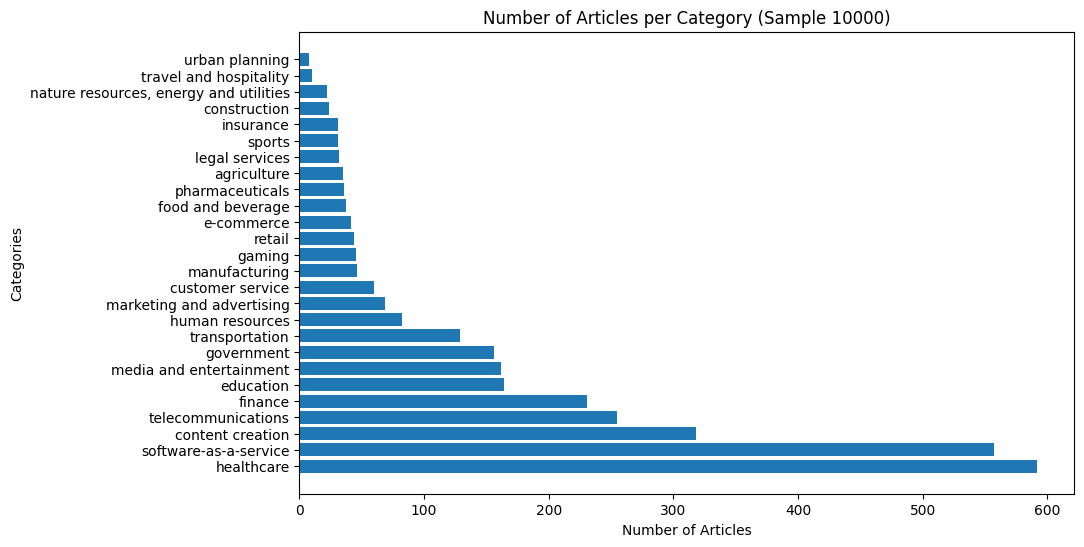

In [410]:
plt.figure(figsize=(10, 6))
plt.barh(pos_cats['cats'], pos_cats['index'])
plt.ylabel('Categories')
plt.xlabel('Number of Articles')
plt.title('Number of Articles per Category (Sample 10000)')
plt.show()

In [284]:
cat_df_cnt[cat_df_cnt['sentiment']=='NEGATIVE'][['cats', 'index', 'percentage']].sort_values('percentage', ascending=False)

,cats,index,percentage
27,gaming,24,17.52
75,travel and hospitality,4,17.39
30,government,87,12.63
9,content creation,96,11.64
51,media and entertainment,50,11.42
69,telecommunications,79,11.00
6,construction,6,10.91
36,human resources,24,9.23
42,legal services,6,8.57
54,"nature resources, energy and utilities",5,7.81


In [57]:
# cat_df[(cat_df['sentiment']=='POSITIVE') & (cat_df['cats']=='healthcare')]['title'].values

In [285]:
def print_cat_topics(cat, n_topics):
    doc_complete = cat_df[cat_df['cats'] == cat]['text_clean'].values.tolist()

    filtered_documents = clean_process(doc_complete)
    
    all_documents = [' '.join(item) for item in filtered_documents]

    tm = ktrain.text.get_topic_model(
        texts=all_documents,
        n_topics=n_topics, 
        n_features=10000,
        min_df=5,
        max_df=0.5,
        stop_words='english',
        model_type='lda',
        lda_max_iter=5,
        verbose=1)
    tm.print_topics()
    
    return

In [316]:
print_cat_topics('transportation', 5)

Cleaning done in 1.036820411682129 seconds
Tokenization done in 0.006689786911010742 seconds
Frequency Calculation Time: 0.02138209342956543 seconds
Stop Words Creation Time: 0.0024509429931640625 seconds
Stop Words Filtering Time: 0.0794520378112793 seconds
lang: en
preprocessing texts...
fitting model...
iteration: 1 of max_iter: 5
iteration: 2 of max_iter: 5
iteration: 3 of max_iter: 5
iteration: 4 of max_iter: 5
iteration: 5 of max_iter: 5
done.
topic 0 | congestion day able prnewswire network camera researcher fleet flow experiment
topic 1 | program force capability aircraft stratfi autonomy hivemind shield gray team
topic 2 | inspection damage freight carrier shipper app process user photo operator
topic 3 | city institute google toyota people robot role area news electric
topic 4 | analytics video feature provides incabin revenue sign point share smart


In [397]:
# cat_df[cat_df['cats'] == 'travel and hospitality'][['title','sentiment']].drop_duplicates()['title']

198     Airbnb is Now Using AI to Determine if Their G...
1385    Robotics and AI can ease staffing crisis in Sc...
1492    Leaders to discuss future of AI and data in ho...
1844    Confucius, Beowulf and an AI called Kevin: Eve...
512     HotelPlanner Combines GigBased Travel Agent Pl...
528     Biden and Putin Cook, Build Sand Castles Toget...
890     Microsoft to invest billions in chatbot maker ...
1269    7 of the best beaches to visit in Sussex, hand...
1632         Machine Learning, AI & Big Data Analytics...
2108    Underage profiles on Instagram will be recogni...
3345    Amii invites the world to AI Week with $100,00...
3750    EasyJet holidays looking at AI travel agents t...
3783    Daily Kickoff: McCarthy, Jeffries to visit Isr...
3887    Can ChatGPT revolutionise the travel industry ...
4396    And & Leuven: is artificial intelligence to bl...
4580    Global State of AI (Artificial Intelligence) 2...
4627    Opinion: AI will take us to terrifying, beauti...
5020          